In [1]:
from loadmodules import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import os
from sklearn.mixture import GaussianMixture

%matplotlib inline
rcParams['figure.facecolor'] = 'white'

In [2]:
def get_metallicity_functions(simulation, snapshot=127, subdir='/output/'):
    print('Loading simulation: '+simulation)
    sf = load_subfind(snapshot, dir=simulation+subdir, hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(snapshot, snappath=simulation+subdir, subfind=sf, hdf5=True, loadonlyhalo=0, loadonlytype=[4])
    s.calc_sf_indizes( sf )
    galrad = sf.data['frc2'][0]
    s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )
    
    element = {'H':0, 'He':1, 'C':2, 'N':3, 'O':4, 'Ne':5, 'Mg':6, 'Si':7, 'Fe':8}
    elementnum = {'H':1, 'He':4, 'C':12, 'N':14, 'O':16, 'Ne':20, 'Mg':24, 'Si':28, 'Fe':56}
    #from Asplund et al. (2009) Table 5
    SUNABUNDANCES = {'H':12.0, 'He':10.98, 'C':8.47, 'N':7.87, 'O':8.73, 'Ne':7.97, 'Mg':7.64, 'Si':7.55, 'Fe':7.54}
    for iel,val in enumerate(element):
        s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
        s.data[val+'/H'] -= (SUNABUNDANCES[val] - SUNABUNDANCES['H'])

    s.data['Z/H'] = np.log10(s.data['gz']/0.0127)
    
    starparts = (s.data['age'] > 0) * (s.r()<galrad) * (s.data['subhalo']==0)
    
    print('Redshift of the simulation: {:2.2f}'.format(s.redshift))
    
    Lz = pylab.cross( s.data['pos'], (s.data['vel'] ) )[:,0]
    orbital_energy = s.data['pot'] + 0.5 * np.sum(s.data['vel']**2, axis=1)
    jz = Lz[starparts]
    ii = np.argsort(orbital_energy[starparts])
    eps = jz[ii]
    npm = 50
    eps /= [ np.max(eps[:i+npm]) if i < npm else np.max(eps[i-npm:]) if i > size(ii)-npm else np.max(eps[i-npm:i+npm]) for i in range(size(ii)) ]
    ilist = np.array(list(range(0, len(eps))))# ilist=1,2,3,4,5
    ilist = ilist[ii] # ilist=5,4,3,2,1
    resort = np.argsort(ilist) # resort=5,4,3,2,1
    eps = eps[resort] # eps2=5,4,3,2,1

    # Build feature array: [ε, Energy]
    X = np.vstack((eps,orbital_energy[starparts],
                    np.log10(np.abs(s.data['pos'][:,0][starparts])))).T

    # Fit GMM
    gmm = GaussianMixture(n_components=2, means_init=[[0.0,np.median(orbital_energy[starparts]), -2.0],
                                                    [0.9,np.median(orbital_energy[starparts]), -5.0]],
                                                    covariance_type='full', random_state=42)
    gmm.fit(X)

    # Predict cluster memberships
    decomp_labels = gmm.predict(X)
    median_eps = [np.median(eps[decomp_labels==i]) for i in range(gmm.n_components)]
    sph_label = np.argmin(np.array(median_eps))
    disc_label = np.argmax(np.array(median_eps))

    # Force assign disc_label to clusters with high circularity parameter
    mask = (decomp_labels == sph_label) & (eps > 0.7)# & (s.r()[starparts] < np.percentile(s.r()[starparts][decomp_labels == disc_label], 0.5))
    decomp_labels[mask] = disc_label

    # Force assign sph_label to clusters with high z-coordinate (10kpc)
    mask = (decomp_labels == disc_label) & (np.abs(s.data['pos'][:,0][starparts])*1e3 > 5.)
    decomp_labels[mask] = sph_label

    feh_scs = np.repeat(s.data['Fe/H'][starparts][decomp_labels == sph_label], s.data['nclt'][starparts][decomp_labels == sph_label]) - 0.5
    feh_scs_i = np.repeat(s.data['Fe/H'][starparts][decomp_labels == sph_label], s.data['incl'][starparts][decomp_labels == sph_label]) - 0.5
    mclus_i = s.data['imcl'][starparts][decomp_labels == sph_label].flatten()
    mclus_m = s.data['mclt'][starparts][decomp_labels == sph_label].flatten()
    mclus_m = mclus_m[mclus_i>0]*1e10
    mclus_i = mclus_i[mclus_i>0]*1e10
    clus_age = np.repeat(s.cosmology_get_lookback_time_from_a(s.data['age'][starparts][decomp_labels==sph_label], is_flat=True)
                          - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True), s.data['nclt'][starparts][decomp_labels == sph_label])
    gc_cand_i = (mclus_i > 1e5)
    gc_cand_6 = (mclus_i[mclus_m>0] > 1e5) * (clus_age > 6.)
    gc_cand_10 = (mclus_i[mclus_m>0] > 1e5) * (clus_age > 10.)

    N, binw = np.histogram(feh_scs_i, bins=20, range=[-3,1])
    width = np.diff(binw)
    initial_mdf = N/width
    N,binw = np.histogram(feh_scs[gc_cand_6], bins=20, range=[-3,1])
    intermediate_age_mdf = N/width
    N,binw = np.histogram(feh_scs[gc_cand_10], bins=20, range=[-3,1])
    old_age_mdf = N/width
    
    return [initial_mdf, intermediate_age_mdf, old_age_mdf]

In [3]:
parent_dir = './level4/'
original_mw = sorted([directory for directory in os.listdir(parent_dir) if 'Au' in directory and 'cfea_fiducial' in directory])
lowmass_mw = sorted([directory for directory in os.listdir(parent_dir) if 'L' in directory and 'cfea_fiducial' in directory])
dwarfs = sorted([directory for directory in os.listdir(parent_dir) if 'D' in directory and 'cfea_fiducial' in directory])

simulation_list = original_mw# + lowmass_mw + dwarfs
simulation_list.remove('Au17_cfea_fiducial')

In [4]:
m31_metallicity = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=8, delimiter=',')
mw_catalogue = np.genfromtxt('catalogues_compare/Harris_onlyphotometry.txt', usecols=(0,6,12), delimiter=',', skip_header=1)
mw_metallicity = mw_catalogue[:,0]

In [5]:
initial_mdf = []
intermediate_mdf = []
old_mdf = []

In [6]:
for sim in simulation_list:
    initial, intermediate, old = get_metallicity_functions(parent_dir+sim, snapshot=127)
    initial_mdf.append(initial)
    intermediate_mdf.append(intermediate)
    old_mdf.append(old)

Loading simulation: ./level4/Au06_cfea_fiducial
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00


/tmp/ipykernel_3457227/3129942143.py:14: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
/tmp/ipykernel_3457227/3129942143.py:17: RuntimeWarning: divide by zero encountered in log10
  s.data['Z/H'] = np.log10(s.data['gz']/0.0127)


Loading simulation: ./level4/Au14_cfea_fiducial
galrad= 0.024826176
Found 2875263 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3457227/3129942143.py:14: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
/tmp/ipykernel_3457227/3129942143.py:17: RuntimeWarning: divide by zero encountered in log10
  s.data['Z/H'] = np.log10(s.data['gz']/0.0127)


Redshift of the simulation: 0.00
Loading simulation: ./level4/Au18_cfea_fiducial
galrad= 0.021988682
Found 1937847 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3457227/3129942143.py:14: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
/tmp/ipykernel_3457227/3129942143.py:17: RuntimeWarning: divide by zero encountered in log10
  s.data['Z/H'] = np.log10(s.data['gz']/0.0127)


Redshift of the simulation: 0.00
Loading simulation: ./level4/Au22_cfea_fiducial
galrad= 0.020834247
Found 1527247 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00


/tmp/ipykernel_3457227/3129942143.py:14: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
/tmp/ipykernel_3457227/3129942143.py:17: RuntimeWarning: divide by zero encountered in log10
  s.data['Z/H'] = np.log10(s.data['gz']/0.0127)


Loading simulation: ./level4/Au23_cfea_fiducial
galrad= 0.024249291
Found 1704041 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3457227/3129942143.py:14: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
/tmp/ipykernel_3457227/3129942143.py:17: RuntimeWarning: divide by zero encountered in log10
  s.data['Z/H'] = np.log10(s.data['gz']/0.0127)


Redshift of the simulation: 0.00
Loading simulation: ./level4/Au24_cfea_fiducial
galrad= 0.024267228
Found 1735362 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3457227/3129942143.py:14: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
/tmp/ipykernel_3457227/3129942143.py:17: RuntimeWarning: divide by zero encountered in log10
  s.data['Z/H'] = np.log10(s.data['gz']/0.0127)


Redshift of the simulation: 0.00
Loading simulation: ./level4/Au26_cfea_fiducial
galrad= 0.02422835
Found 2664011 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3457227/3129942143.py:14: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
/tmp/ipykernel_3457227/3129942143.py:17: RuntimeWarning: divide by zero encountered in log10
  s.data['Z/H'] = np.log10(s.data['gz']/0.0127)


Redshift of the simulation: 0.00
Loading simulation: ./level4/Au27_cfea_fiducial
galrad= 0.025470624
Found 2678961 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3457227/3129942143.py:14: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
/tmp/ipykernel_3457227/3129942143.py:17: RuntimeWarning: divide by zero encountered in log10
  s.data['Z/H'] = np.log10(s.data['gz']/0.0127)


Redshift of the simulation: 0.00
Loading simulation: ./level4/Au28_cfea_fiducial
galrad= 0.024573132
Found 2686170 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3457227/3129942143.py:14: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
/tmp/ipykernel_3457227/3129942143.py:17: RuntimeWarning: divide by zero encountered in log10
  s.data['Z/H'] = np.log10(s.data['gz']/0.0127)


Redshift of the simulation: 0.00


In [7]:
def first_char_index(text, char):
    """
    Returns the index of the first appearance of `char` in `text`.
    Returns -1 if `char` is not found.
    """
    try:
        return text.index(char)
    except ValueError:
        return -1

/tmp/ipykernel_3457227/2817222812.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


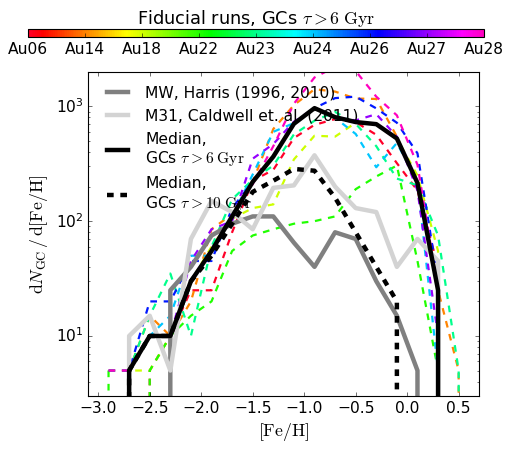

In [8]:
fig, ax = plt.subplots(figsize=(6,5))

Nmw, binw = np.histogram(mw_metallicity, bins=20, range=[-3,1])
width = np.diff(binw)
plot_xarray = (binw[1:]+binw[:-1])/2.
Nm31, binw = np.histogram(m31_metallicity, bins=20, range=[-3,1])

# Set up colormap
cmap = cm.gist_rainbow   # Or "viridis", "inferno", etc.
norm = colors.Normalize(vmin=0, vmax=len(simulation_list)-1)

for i in range(len(simulation_list)):
    ax.plot(plot_xarray, intermediate_mdf[i], linewidth=2, color=cmap(norm(i)), linestyle='--')

ax.plot(plot_xarray, Nmw/width, label='MW, Harris (1996, 2010)', linewidth=4, color='grey')
ax.plot(plot_xarray, Nm31/width, label='M31, Caldwell et. al. (2011)', linewidth=4, color='lightgrey')
ax.plot(plot_xarray, np.median(np.array(intermediate_mdf), axis=0), color='k', linewidth=4, label='Median,'+'\n'+r'GCs $\tau > 6 \;\rm{Gyr}$')
ax.plot(plot_xarray, np.median(np.array(old_mdf), axis=0), color='k', linestyle='--', linewidth=4, label='Median,'+'\n'+r'GCs $\tau > 10 \;\rm{Gyr}$')

# Add colorbar as legend
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar
cbar = fig.colorbar(sm, cax=fig.add_axes([0.03, 1.05, .95, 0.02]), orientation='horizontal')
cbar.ax.set_title('Fiducial runs, GCs '+r'$\tau > 6 \;\rm{Gyr}$', fontsize=16)
cbar.set_ticks(np.arange(0, len(simulation_list), 1))  # adjust ticks (optional)
cbar.set_ticklabels([simulation_list[i][:first_char_index(simulation_list[i],'_')] for i in range(len(simulation_list))])
cbar.ax.tick_params(labelsize=14)

ax.set_yscale('log')
ax.legend(loc='upper left', fontsize=14, frameon=False)
ax.set_xlabel(r'$\mathrm{[Fe/H]}$', fontsize=16)
ax.set_ylabel(r'$\mathrm{d} N_{\mathrm{GC}} \, / \, \mathrm{d} [\mathrm{Fe/H}]$', fontsize=16)
ax.set_xlim(-3.1, 0.7)
ax.set_ylim(3e0, 2e3)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
# plt.savefig('plots/metallicity_distribution_paper.pdf', bbox_inches='tight')

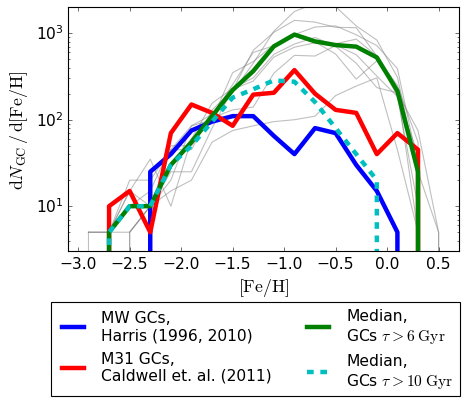

In [9]:
fig, ax = plt.subplots(figsize=(6,4))

Nmw, binw = np.histogram(mw_metallicity, bins=20, range=[-3,1])
width = np.diff(binw)
plot_xarray = (binw[1:]+binw[:-1])/2.
Nm31, binw = np.histogram(m31_metallicity, bins=20, range=[-3,1])


for i in range(len(simulation_list)):
    ax.plot(plot_xarray, intermediate_mdf[i], linewidth=1, color='grey', alpha=0.5)

ax.plot(plot_xarray, Nmw/width, label='MW GCs,'+'\n'+'Harris (1996, 2010)', linewidth=4, color='b')
ax.plot(plot_xarray, Nm31/width, label='M31 GCs,'+'\n'+'Caldwell et. al. (2011)', linewidth=4, color='r')
ax.plot(plot_xarray, np.median(np.array(intermediate_mdf), axis=0), color='g', linewidth=4, label='Median,'+'\n'+r'GCs $\tau > 6 \;\rm{Gyr}$')
ax.plot(plot_xarray, np.median(np.array(old_mdf), axis=0), color='c', linestyle='--', linewidth=4, label='Median,'+'\n'+r'GCs $\tau > 10 \;\rm{Gyr}$')

# # Add colorbar as legend
# sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  # Required for colorbar
# cbar = fig.colorbar(sm, cax=fig.add_axes([0.03, 1.05, .95, 0.02]), orientation='horizontal')
# cbar.ax.set_title('Fiducial runs, GCs '+r'$\tau > 6 \;\rm{Gyr}$', fontsize=14)
# cbar.set_ticks(np.arange(0, len(simulation_list), 1))  # adjust ticks (optional)
# cbar.set_ticklabels([simulation_list[i][:first_char_index(simulation_list[i],'_')] for i in range(len(simulation_list))])
# cbar.ax.tick_params(labelsize=14)

ax.set_yscale('log')
ax.set_xlabel(r'$\mathrm{[Fe/H]}$', fontsize=16)
ax.set_ylabel(r'$\mathrm{d} N_{\mathrm{GC}} \, / \, \mathrm{d} [\mathrm{Fe/H}]$', fontsize=16)
ax.set_xlim(-3.1, 0.7)
ax.set_ylim(3e0, 2e3)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.legend(loc='center', bbox_to_anchor=(0.48, -0.4), fontsize=14, frameon=True, ncol=2)
plt.savefig('plots/metallicity_distribution_paper.pdf', bbox_inches='tight')